# CASO PRACTICO 1: COVID 19
## COVID_DATA
## Descripción de los datos utilizados

El conjunto de datos utilizado proviene de el Gobierno de México, en un archivo csv llamado Covid_Data y contiene información sobre pacientes con Covid-19. Las características incluyen:

- **USMER**: Unidad de atención médica.
- **MEDICAL_UNIT**: Unidad médica asignada.
- **SEX**: Género del paciente.
- **PATIENT_TYPE**: Tipo de paciente (hospitalizado, ambulatorio, etc.).
- **DATE_DIED**: Fecha de fallecimiento (si aplica).
- **INTUBED**: Si el paciente fue intubado.
- **PNEUMONIA**: Presencia de neumonía.
- **AGE**: Edad del paciente.
- **PREGNANT**: Estado de embarazo.
- **DIABETES**: Presencia de diabetes.
- **COPD**: Enfermedad pulmonar obstructiva crónica.
- **ASTHMA**: Presencia de asma.
- **INMSUPR**: Inmunosupresión.
- **HIPERTENSION**: Presencia de hipertensión.
- **OTHER_DISEASE**: Otras enfermedades.
- **CARDIOVASCULAR**: Enfermedades cardiovasculares.
- **OBESITY**: Obesidad.
- **RENAL_CHRONIC**: Enfermedad renal crónica.
- **TOBACCO**: Uso de tabaco.
- **CLASIFFICATION_FINAL**: Clasificación final del paciente.
- **ICU**: Si el paciente fue admitido en la UCI.

Este conjunto de datos permite analizar diversos factores de riesgo que pueden influir en la evolución de la enfermedad.


### Carga de datos y librerías
Primero cargamos las librerías principales que usaremos para manipular los datos y el conjunto de datos proporcionado. El dataset contiene información detallada sobre pacientes de Covid-19, con varias características que abarcan síntomas, estado actual e historial médico.

In [90]:
%matplotlib inline

# Cargar las librerías necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import confusion_matrix, accuracy_score

#import SMOTE

# Cargar el dataset
covid = pd.read_csv('/home/jesus_gh/MetodosBiomAI/Covid_Data.csv')

### Preprocesamiento de datos
Para preparar los datos, convertimos las columnas booleanas (donde 1 significa "sí" y 2 significa "no") a valores binarios (1 y 0) que pueden ser usados en el modelo. Además, se manejan los valores nulos (97, 98 y 99) reemplazándolos por `NaN`. Finalmente, la columna `DATE_DIED` se convierte en una variable binaria, donde 1 representa que el paciente falleció.

In [91]:
# Convertir 1 a 1 y 2 a 0, y manejar valores faltantes (97, 99)
bool_cols = ['SEX', 'PNEUMONIA', 'PREGNANT', 'DIABETES', 'COPD', 'ASTHMA', 'INMSUPR', 
             'HIPERTENSION', 'CARDIOVASCULAR', 'OBESITY', 'RENAL_CHRONIC', 'TOBACCO', 
             'INTUBED', 'ICU']

for col in bool_cols:
    covid[col] = covid[col].replace({1: 1, 2: 0, 97: np.nan, 99: np.nan, 98: np.nan})

# Convertir 'DATE_DIED' en una columna booleana donde 1 es muerte y 0 es no muerte
covid['DATE_DIED'] = covid['DATE_DIED'].apply(lambda x: 0 if x == '9999-99-99' else 1)

### Manejo de valores faltantes
Aquí se revisa el número de valores faltantes en cada columna del dataset. Posteriormente, eliminamos las filas que contienen valores `NaN`, ya que esto puede afectar el rendimiento del modelo. Finalmente, verificamos cuántas filas quedan después de la limpieza.


In [92]:
# Verificar cuántos valores faltantes hay en cada columna
print(covid.isnull().sum())

# Eliminar filas que contienen valores NaN en cualquier columna
covid = covid.dropna()

# Verificar cuántas filas quedan después de la eliminación
print(f"Filas restantes después de eliminar NaN: {covid.shape[0]}")

USMER                        0
MEDICAL_UNIT                 0
SEX                          0
PATIENT_TYPE                 0
DATE_DIED                    0
INTUBED                 855869
PNEUMONIA                16003
AGE                          0
PREGNANT                527265
DIABETES                  3338
COPD                      3003
ASTHMA                    2979
INMSUPR                   3404
HIPERTENSION              3104
OTHER_DISEASE                0
CARDIOVASCULAR            3076
OBESITY                   3032
RENAL_CHRONIC             3006
TOBACCO                   3220
CLASIFFICATION_FINAL         0
ICU                     856032
dtype: int64
Filas restantes después de eliminar NaN: 77100


### Creación de la variable objetivo (RISK)
La columna `CLASIFFICATION_FINAL` indica el diagnóstico de Covid-19 del paciente. Se crea una nueva columna `RISK` donde los valores 1, 2 y 3 (pacientes con Covid) se asignan como "alto riesgo" (1), y los valores 4 o superiores como "bajo riesgo" (0).

In [93]:
# Crear columna de riesgo (1: alto riesgo, 0: bajo riesgo)
covid['RISK'] = covid['CLASIFFICATION_FINAL'].apply(lambda x: 1 if x in [1, 2, 3] else 0)

# Revisar el conteo de valores
#covid['RISK'].value_counts()

### Undersampling de RISK == 1
Quisimos hacer un undersampling para que el tamaño de muestras de risk 1 y risk 0 sean iguales...

In [94]:
# Código de submuestreo
risk_1 = covid[covid['RISK'] == 1]
risk_0 = covid[covid['RISK'] == 0]

# Realizar submuestreo en la clase 'RISK=1' para que tenga 35640 filas
risk_1_sampled = risk_1.sample(n=35640, random_state=42)

# Concatenar las dos clases para crear el dataset balanceado
covid_balanced = pd.concat([risk_1_sampled, risk_0])

# Mezclar aleatoriamente el dataset
covid_balanced = covid_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

# Verificar la distribución de las clases
print(covid_balanced['RISK'].value_counts())


RISK
1    35640
0    35640
Name: count, dtype: int64


### Gráficas diversas
Gráficas de distribuciones y proporciones:
1. Distribución de Riesgo (Alto vs Bajo)
2. Distribución de la edad por nivel de riesgo
3. Proporción de pacientes con hipertensión según el riesgo
4. Proporción de pacientes en UCI por nivel de riesgo
5. Mapa de calor de la correlación entre las variables numéricas

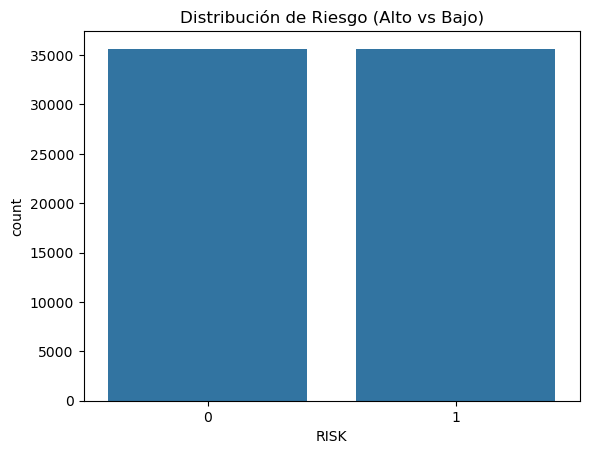

In [95]:
import seaborn as sns
import matplotlib.pyplot as plt

# Distribución de la variable objetivo
sns.countplot(x='RISK', data=covid_balanced)
plt.title('Distribución de Riesgo (Alto vs Bajo)')
plt.show()

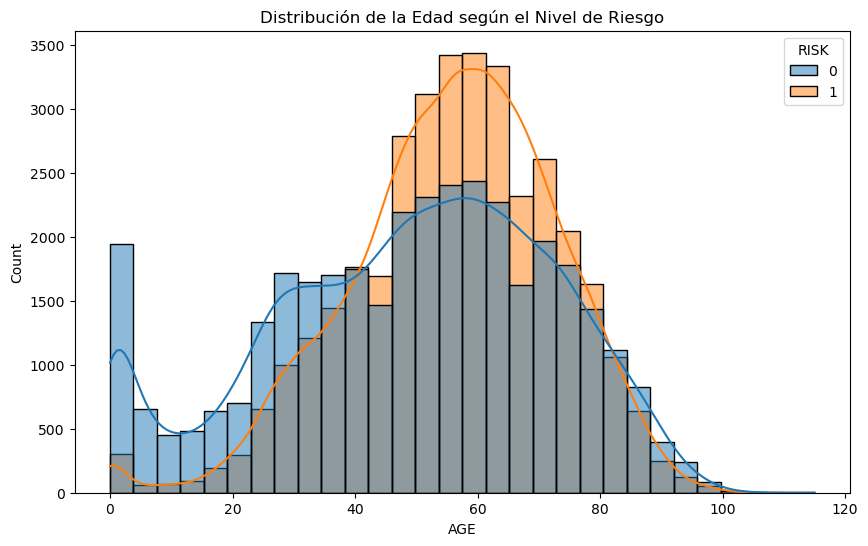

In [96]:
# Distribución de la edad por nivel de riesgo
plt.figure(figsize=(10, 6))
sns.histplot(data=covid_balanced, x='AGE', hue='RISK', bins=30, kde=True)
plt.title('Distribución de la Edad según el Nivel de Riesgo')
plt.show()

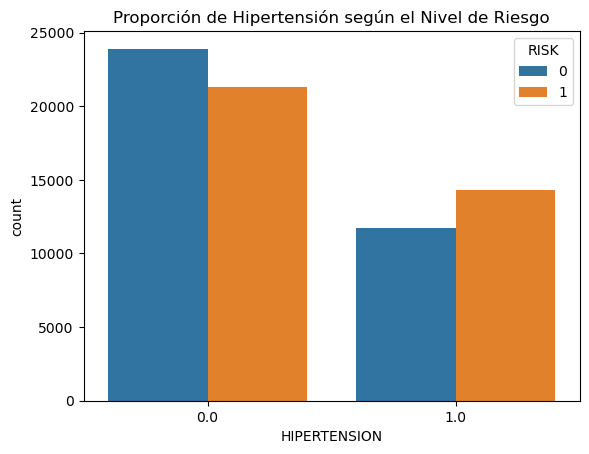

In [97]:
# Proporción de pacientes con hipertensión según el riesgo
sns.countplot(x='HIPERTENSION', hue='RISK', data=covid_balanced)
plt.title('Proporción de Hipertensión según el Nivel de Riesgo')
plt.show()

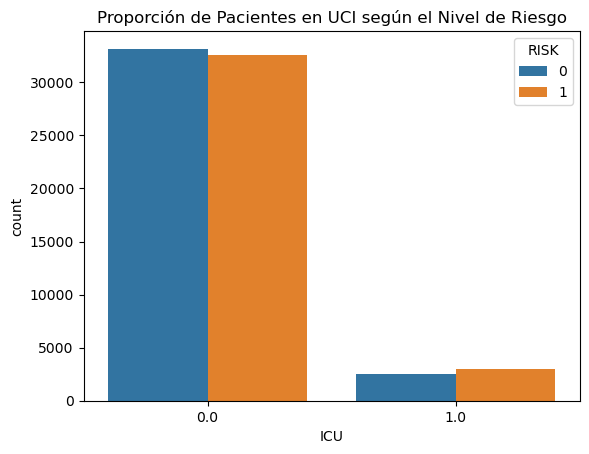

In [98]:
# Proporción de pacientes en UCI por nivel de riesgo
sns.countplot(x='ICU', hue='RISK', data=covid_balanced)
plt.title('Proporción de Pacientes en UCI según el Nivel de Riesgo')
plt.show()

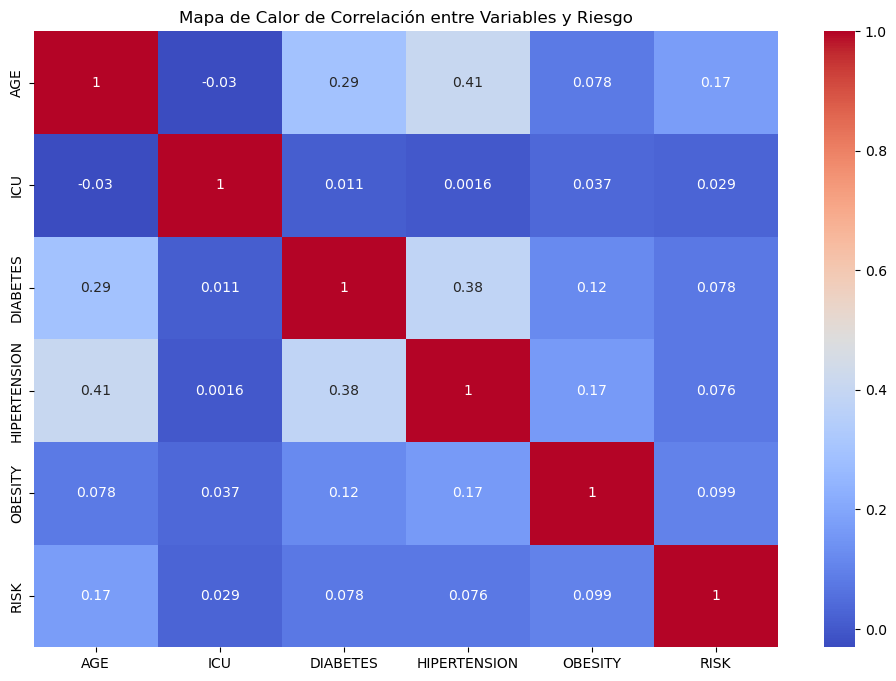

In [99]:
# Mapa de calor de la correlación entre las variables numéricas
plt.figure(figsize=(12, 8))
corr = covid_balanced[['AGE', 'ICU', 'DIABETES', 'HIPERTENSION', 'OBESITY', 'RISK']].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Mapa de Calor de Correlación entre Variables y Riesgo')
plt.show()

## Análisis exploratorio de las características


### JUSTIFICACIÓN de selección de características:
En el contexto de predicción de alto riesgo en pacientes con COVID-19 algunas características tienen un mayor impacto que otras. 
A continuación, se presenta un análisis detallado de las variables más útiles y menos útiles para predecir el riesgo en estos pacientes, basado en estudios de referencia y datos empíricos recopilados desde el inicio de la pandemia:

##### 1. SEXO
Los estudios han demostrado que los hombres tienen un mayor riesgo de complicaciones graves por COVID-19 en comparación con las mujeres. Este fenómeno puede estar relacionado con factores biológicos, hormonales, y de comportamiento. Los hombres suelen tener mayores tasas de comorbilidades (como hipertensión y enfermedades cardíacas) y pueden tener una respuesta inmune menos efectiva.
  Impacto: Moderado. Aunque el sexo afecta el riesgo, no es tan determinante como otras comorbilidades. Los hombres tienen más probabilidades de sufrir casos graves, pero esto puede depender de otros factores como la edad y las comorbilidades.
"Sex differences in immune responses that underlie COVID-19 disease outcomes", por Takahashi et al. (2020). 
https://www.nature.com/articles/s41591-020-0965-6

##### 2. EDAD
La edad es uno de los factores más determinantes en la predicción de riesgo. Los adultos mayores, especialmente aquellos mayores de 65 años, tienen un riesgo mucho mayor de complicaciones graves y muerte debido a la debilitación del sistema inmunológico y la prevalencia de enfermedades crónicas.
 Impacto: Muy alto. La edad avanzada se ha correlacionado fuertemente con un mayor riesgo de hospitalización, intubación y mortalidad en pacientes con COVID-19 y mayor probabilidad de desarrollar insuficiencia respiratoria
Risk Factors Associated With Acute Respiratory Distress Syndrome and Death in Patients With Coronavirus Disease 2019 Pneumonia in Wuhan, China,  por Wu et al. (2020). 
https://jamanetwork.com/journals/jamainternalmedicine/fullarticle/2763184

##### 3. NEUMONÍA
La neumonía es una de las complicaciones más comunes y graves del COVID-19. Los pacientes que desarrollan neumonía tienen una mayor probabilidad de requerir cuidados intensivos, intubación y ventilación mecánica, debido a la afectación severa de los pulmones.
Impacto: Muy alto. La presencia de neumonía es un fuerte predictor de severidad y puede ser indicativa de un peor pronóstico. La neumonía es un factor clave para la gravedad de la enfermedad y está fuertemente correlacionada con la mortalidad.
Clinical Characteristics and Outcomes of Patients with Severe COVID-19 and Acute Respiratory Distress Syndrome, por Yang et al. (2020). https://www.thelancet.com/journals/lanres/article/PIIS2213-2600(20)30079-5/fulltext

##### 4. EMBARAZO
Aunque el embarazo se consideró un factor de riesgo durante la pandemia, las mujeres embarazadas en su mayoría no presentaron mayores tasas de mortalidad, aunque sí tuvieron mayor probabilidad de hospitalización y parto prematuro. Los cambios inmunológicos y fisiológicos durante el embarazo aumentan la susceptibilidad a infecciones respiratorias graves.
 Impacto: Moderado. El embarazo aumenta el riesgo de complicaciones, pero no es tan determinante como otras condiciones crónicas o la edad avanzada.
Characteristics and outcomes of women with COVID-19 giving birth: COVID-19 in-pregnancy and early neonatal outcomes (COVID-IPO), por Allotey et al. (2020). https://www.bmj.com/content/370/bmj.m3320

##### 5. DIABETES
La diabetes está fuertemente relacionada con un mayor riesgo de complicaciones por COVID-19. Las personas diabéticas tienen un sistema inmunológico comprometido y suelen tener problemas para controlar los niveles de glucosa durante una infección, lo que puede agravar el estado del paciente.
Impacto: Alto. Los pacientes diabéticos tienen mayor riesgo de hospitalización, ingreso a UCI e incluso muerte. La hiperglucemia no controlada se asocia con una respuesta inflamatoria severa, lo que agrava la enfermedad.
Association of Diabetes and COVID-19 Outcomes, por Huang et al. (2020).
https://diabetes.diabetesjournals.org/content/69/10/2088

##### 6.  EPOC (Enfermedad Pulmonar Obstructiva Crónica) 
Los pacientes con EPOC tienen una función pulmonar comprometida, lo que los hace especialmente vulnerables a infecciones respiratorias graves, como COVID-19. Estos pacientes suelen tener más dificultades para combatir la enfermedad y requieren hospitalización más frecuentemente.
Impacto: Muy alto. La EPOC es una de las comorbilidades más relevantes en términos de riesgo respiratorio grave por COVID-19.
COPD and the risk of severe COVID-19: A nationwide cohort study, por Attaway et al. (2020).
https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7344724/

##### 7. ASMA (Síntomas prolongados y empeoramiento del control del asma) 
Aunque el asma se consideraba inicialmente un factor de riesgo importante, estudios posteriores mostraron que los pacientes con asma leve o moderada no presentan un riesgo significativamente mayor de complicaciones graves. Sin embargo, aquellos con asma grave y síntomas mal controlados tienen un mayor riesgo.
Asthma and Risk of Severe COVID-19: A Population-Based Cohort Study, por Williamson et al. (2020). El asma leve no parece aumentar el riesgo, pero el asma grave sí.
https://www.thelancet.com/journals/lancet/article/PIIS0140-6736(20)30984-6/fulltext

##### 8. INMUNOSUPRESOR
Los pacientes inmunosuprimidos, ya sea por medicamentos o condiciones subyacentes (cáncer, trasplante de órganos), tienen una capacidad reducida para combatir infecciones, lo que los pone en alto riesgo de complicaciones graves.
Impacto: Muy alto. Los inmunosuprimidos son uno de los grupos más vulnerables, con mayores tasas de hospitalización y mortalidad.
Outcomes of COVID-19 in hospitalized patients with and without immunosuppressive medication, por Kalil et al. (2020). https://www.nejm.org/doi/full/10.1056/NEJMoa2021436

##### 9. HIPERTENSIÓN
La hipertensión es una de las comorbilidades más comunes en pacientes con COVID-19, y estudios han encontrado que los hipertensos tienen un mayor riesgo de complicaciones graves, posiblemente debido a la relación entre la hipertensión y las enfermedades cardiovasculares y renales.
Impacto: Moderado. Aunque la hipertensión por sí sola puede no ser un factor determinante, es común en pacientes con otras comorbilidades que sí son importantes, lo que eleva el riesgo general.
Hypertension and COVID-19: Risks and Management, por Savoia et al. (2020). https://www.ahajournals.org/doi/full/10.1161/HYPERTENSIONAHA.120.15072

##### 10. ENFERMEDAD CARDIOVASCULAR
Las enfermedades cardiovasculares se asocian con un peor pronóstico en casos de COVID-19. El virus puede agravar estas condiciones al causar inflamación sistémica y estrés en el sistema circulatorio.
Impacto: Muy alto. Las enfermedades cardíacas aumentan significativamente el riesgo de complicaciones graves y muerte.
Cardiovascular disease, drug therapy, and mortality in COVID-19, por Guo et al. (2020). https://jamanetwork.com/journals/jamacardiology/fullarticle/2763844

##### 11. ENFERMEDAD RENAL CRÓNICA
La enfermedad renal crónica afecta la capacidad del cuerpo para regular fluidos y eliminar toxinas, lo que puede complicar la respuesta del cuerpo a una infección como COVID-19. Además, estos pacientes suelen tener otras comorbilidades graves.
Impacto: Alto. La enfermedad renal crónica es un factor de riesgo importante para el desarrollo de complicaciones severas.
Chronic kidney disease and outcomes of patients with COVID-19, por Cheng et al. (2020). https://www.kidney-international.org/article/S0085-2538(20)30255-6/fulltext

##### 12. OBESIDAD 
La obesidad es un fuerte predictor de complicaciones graves por COVID-19. Los pacientes obesos tienen mayor riesgo de hospitalización, necesidad de ventilación mecánica y muerte debido a la afectación pulmonar y sistémica.
Impacto: Muy alto. La obesidad, especialmente la mórbida, es uno de los factores de riesgo más importantes para complicaciones graves.

##### 13. TABACO
El consumo de tabaco está asociado con un mayor riesgo de enfermedades respiratorias crónicas y cáncer de pulmón, lo que hace que los fumadores sean más susceptibles a complicaciones graves en caso de infección por COVID-19.
Impacto: Moderado. Fumar puede aumentar el riesgo de complicaciones respiratorias, pero su impacto no es tan determinante como otras condiciones.
Tobacco smoking and COVID-19 infection: A systematic review, por Patanavanich y Glantz (2020). https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0236765

##### 14. INTUBACIÓN
La necesidad de intubación en un paciente con COVID-19 indica una insuficiencia respiratoria severa. Los pacientes que requieren intubación tienen una alta tasa de mortalidad y, si sobreviven, pueden enfrentar una larga recuperación.
Impacto: Muy alto. La intubación es un indicador de que el paciente está en una situación crítica.

#### 15. SI ESTUVO EN UNIDAD DE CUIDADOS INTENSIVOS (UCI)
Haber estado en la UCI es un claro indicador de la gravedad de la enfermedad. Los pacientes que han estado en UCI son aquellos con complicaciones más severas, y esto puede predecir un peor pronóstico en caso de reinfección o futuras complicaciones.
Impacto: Muy alto. Estar en la UCI es una señal de alto riesgo y puede predecir futuros episodios graves.


#### Características menos útiles:
TABACO: Aunque el consumo de tabaco es un factor de riesgo, su impacto directo en la gravedad del COVID-19 no es tan determinante como las comorbilidades crónicas.
ASMA leve: El asma leve o bien controlada no parece aumentar significativamente el riesgo de complicaciones graves.

## Conclusión:
Las características más útiles para predecir el riesgo en pacientes con COVID-19 incluyen la edad, neumonía, diabetes, EPOC, inmunosupresión, enfermedad cardiovascular, enfermedad renal crónica, y obesidad. Estas condiciones están fuertemente asociadas con la gravedad de la enfermedad y un mayor riesgo de muerte.


Se realizó un análisis exploratorio de los datos para identificar tendencias, patrones y posibles correlaciones entre las características y el riesgo de complicaciones por Covid-19. Algunas observaciones clave incluyen:

- La distribución de la edad muestra que los pacientes mayores tienden a presentar un mayor riesgo.
- Las gráficas de correlación indican que ciertas condiciones preexistentes, como diabetes están fuertemente asociadas con un mayor riesgo de complicaciones.
- El análisis de la distribución de pacientes intubados en relación con la clasificación final revela información crítica sobre el manejo de casos severos.

In [100]:
# Crear subconjuntos de datos a partir del dataset balanceado
sintomas_actuales = covid_balanced[['PNEUMONIA', 'INTUBED']]
estado_actual = covid_balanced[['AGE', 'ICU', 'PATIENT_TYPE','DATE_DIED']]
historial_medico = covid_balanced[['DIABETES', 'COPD', 'ASTHMA', 'INMSUPR', 'HIPERTENSION', 
                                   'CARDIOVASCULAR', 'RENAL_CHRONIC', 'OBESITY']]


### Normalización de datos
Algunas variables, como la edad (`AGE`), pueden tener un rango de valores muy amplio, lo que podría afectar negativamente al modelo. Para solucionar esto, normalizamos dicha variable usando un `StandardScaler`.

In [101]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

# Normalizar la columna AGE
#scaler = StandardScaler()
#covid_balanced[['AGE']] = scaler.fit_transform(covid_balanced[['AGE']])
#covid_balanced[['AGE','RISK']].head()

# Escalar todas las características numéricas (opcional: podrías usar también StandardScaler)
scaler = MinMaxScaler(feature_range=(0, 1))  # Normalizar a un rango entre 0 y 1
X_scaled = scaler.fit_transform(X)  # Normalizar todas las características numéricas


### Entrenamiento del modelo de regresión logística
En esta sección, concatenamos las características seleccionadas para formar la matriz `X`, mientras que la columna `RISK` es la variable objetivo (`y`). Dividimos los datos en conjuntos de entrenamiento y prueba, y entrenamos un modelo de regresión logística utilizando las características seleccionadas.

### Explicación de la implementación del modelo de regresión logística

La regresión logística fue elegida como el modelo para predecir el riesgo de complicaciones en pacientes con Covid-19 debido a su capacidad para modelar relaciones lineales entre las variables independientes y la variable dependiente binaria (RISK). 

El proceso de implementación incluyó los siguientes pasos:

1. **División de datos**: Se separaron los datos en conjuntos de entrenamiento y prueba para evaluar el rendimiento del modelo.
2. **Normalización**: Las características fueron normalizadas para garantizar que todas estuvieran en la misma escala.
3. **Entrenamiento**: Se utilizó el conjunto de entrenamiento para ajustar el modelo a los datos.
4. **Predicción**: Se aplicó el modelo a los datos de prueba para predecir los resultados.


In [105]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score 
from sklearn.metrics import confusion_matrix, accuracy_score

# Concatenar los subconjuntos para crear la matriz de características (X)
X = pd.concat([sintomas_actuales, estado_actual, historial_medico], axis=1)

# Variable objetivo (RISK)
y = covid_balanced['RISK']

# Dividir el dataset en entrenamiento (80%) y prueba (20%)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Entrenar el modelo de regresión logística
model = LogisticRegression(penalty='l2', C=100,max_iter=1000)
model.fit(X_train, y_train)

LogisticRegression(C=100, max_iter=1000)

In [103]:
print(covid_balanced.head())

   USMER  MEDICAL_UNIT  SEX  PATIENT_TYPE  DATE_DIED  INTUBED  PNEUMONIA  AGE  \
0      1            12    1             2          1      1.0        1.0   60   
1      2            12    1             2          1      0.0        1.0   58   
2      1            12    1             2          1      1.0        1.0   57   
3      2             4    1             2          0      0.0        1.0   62   
4      1             4    1             2          0      0.0        1.0   50   

   PREGNANT  DIABETES  ...  INMSUPR  HIPERTENSION  OTHER_DISEASE  \
0       0.0       0.0  ...      0.0           0.0              2   
1       0.0       0.0  ...      0.0           0.0              2   
2       0.0       0.0  ...      0.0           0.0              2   
3       0.0       1.0  ...      0.0           0.0              2   
4       0.0       1.0  ...      0.0           0.0              2   

   CARDIOVASCULAR  OBESITY  RENAL_CHRONIC  TOBACCO  CLASIFFICATION_FINAL  ICU  \
0             0.0      

### Evaluación del modelo
Después de entrenar el modelo, lo evaluamos utilizando la precisión (`accuracy`), que nos dice qué porcentaje de las predicciones fue correcto. Sin embargo, más adelante evaluaremos otras métricas como el AUC para obtener una visión más completa del rendimiento.

In [107]:
# Predecir los valores de prueba
y_pred = model.predict(X_test)

# Evaluar el modelo usando la precisión (accuracy)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

Accuracy: 0.6218434343434344


### Evaluación de los coeficientes: 
Para asegurarnos de que las características estén afectando correctamente el modelo. Es útil ver los coeficientes ajustados de la regresión logística:

In [108]:
print("Coeficientes:", model.coef_)
print("Intercepto:", model.intercept_)

Coeficientes: [[ 0.45191592  0.26918451  1.37650186 -0.05676109  0.          0.66268695
   0.08994513 -0.54769067 -0.07329658 -0.56838054 -0.01725156 -0.53404039
  -0.48723924  0.39981661]]
Intercepto: [-1.11537277]


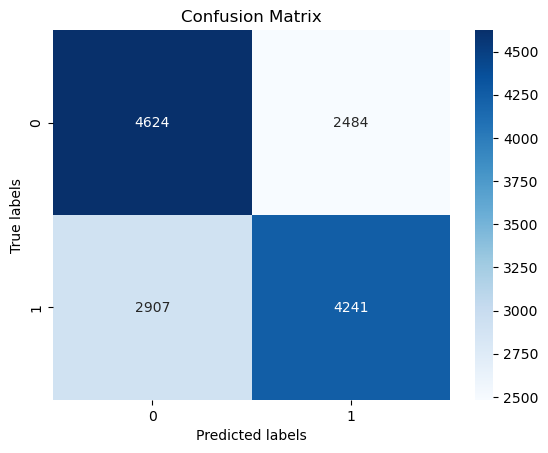

In [109]:
conf_matrix = confusion_matrix(y_test, y_pred)

fig, ax = plt.subplots()

sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', ax=ax)

ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')

plt.show()

### Evaluación adicional: AUC y curva ROC
Además de la precisión, calculamos el AUC (Área bajo la curva ROC), que es una métrica más robusta para evaluar el rendimiento del modelo en problemas de clasificación binaria. También graficamos la curva ROC para visualizar el trade-off entre la tasa de verdaderos positivos y la tasa de falsos positivos.

AUC: 0.6729912566497422


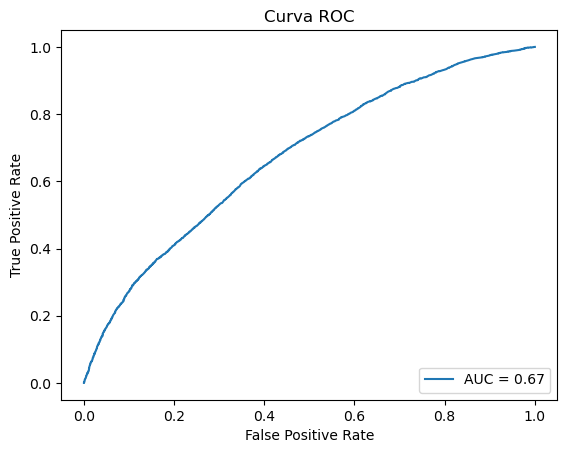

In [110]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve

# Asegurarte de usar %matplotlib inline en un Jupyter Notebook
%matplotlib inline

# Predecir probabilidades para el cálculo de AUC
y_prob = model.predict_proba(X_test)[:, 1]

# Calcular AUC
auc = roc_auc_score(y_test, y_prob)
print(f"AUC: {auc}")

# Graficar la curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
plt.plot(fpr, tpr, label=f'AUC = {auc:.2f}')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC')
plt.legend(loc='lower right')
plt.show()


## Discusión de las métricas de evaluación del modelo

Para evaluar el rendimiento del modelo se utilizaron diversas métricas:

- **Precisión**: Indica la proporción de verdaderos positivos sobre el total de predicciones positivas. Una alta precisión es deseable en el contexto de clasificación de riesgos.
- **Sensibilidad**: Refleja la capacidad del modelo para identificar correctamente a los pacientes en riesgo. Es crítica en entornos clínicos para evitar falsos negativos.
- **Especificidad**: Mide la capacidad del modelo para identificar correctamente a los pacientes que no están en riesgo, lo cual es igualmente importante.
- **AUC y ROC**: La curva ROC y el área bajo la curva (AUC) proporcionan una visión general del rendimiento del modelo a través de diferentes umbrales de clasificación, permitiendo una evaluación más completa de su efectividad.

Estas métricas son esenciales para determinar la utilidad clínica del modelo en la predicción de complicaciones por Covid-19.
